<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/IVT_iter1_1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from collections import OrderedDict 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime as tm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
plt.clf()

<Figure size 432x288 with 0 Axes>

In [3]:
%matplotlib inline

#Import and clean the data

In [4]:
path='/content/drive/My Drive/Thesis/Iter1.1/iter1.1-restored.xlsx'
df=pd.read_excel(path,header=2)#,usecols=(lambda x: type(x) is not str))
#df.drop(labels='Time [s]',axis=1,inplace=True)
df

,Temperature,370,370.1,370.2,370.3,370.4,370.5,370.6,370.7,369,370.8,370.9,370.10,370.11,369.1,370.12,370.13,370.14,370.15,370.16,370.17,370.18,370.19,369.2,370.20,370.21,369.3,370.22,370.23,370.24,370.25,370.26,370.27,370.28,370.29,370.30,370.31,370.32,370.33,370.34,...,370.181,370.182,370.183,370.184,370.185,370.186,370.187,370.188,370.189,370.190,370.191,370.192,370.193,370.194,370.195,370.196,370.197,370.198,370.199,370.200,369.25,370.201,370.202,370.203,370.204,370.205,370.206,370.207,370.208,369.26,369.27,370.209,369.28,370.210,369.29,370.211,370.212,370.213,370.214,370.215
0,A10,989,1439,2361,3673,5120,6574,8058,9461,10761,12018,13168,14191,15219,16056,16917,18111,18953,19690,20352,21150,21845,22648,23408,24211,24884,25629,26259,26933,27569,28260,28757,29306,30104,30626,31294,31785,32372,32979,33531,...,54792,54837,54712,54733,54676,54786,54597,54730,54900,54583,54543,54596,54649,54697,54673,54590,54673,54775,54797,54666,54643,54501,54630,54581,54646,54543,54422,54551,54642,54539,54528,54890,54775,54743,54771,54682,54631,54714,54604,54713
1,A11,1243,1216,1221,1212,1178,1146,1138,1164,1169,1137,1103,1063,1000,928,919,1025,1046,1043,1033,1029,994,1004,994,1012,1014,1028,1019,1004,970,943,945,940,963,978,968,977,981,982,977,...,925,920,922,925,919,927,923,918,920,922,927,927,922,927,929,921,924,931,932,944,942,943,947,949,954,956,957,960,959,962,968,962,966,972,972,970,978,974,972,977
2,A12,2887,4308,5856,7499,8713,10027,11247,12408,13482,14600,15525,16416,17345,18108,19003,20192,21020,21731,22377,23045,23739,24432,25044,25846,26553,27230,27847,28427,29050,29633,30180,30755,31382,32042,32548,33062,33654,34211,34614,...,70776,71008,70792,70933,70992,70884,70918,70797,71137,71166,70982,71190,70859,71122,70938,71146,71215,71294,71440,71312,71173,71456,71353,71373,71279,71271,71328,71375,71392,71204,71306,71564,71655,71653,71680,71771,71690,71735,71833,71853
3,A13,1252,1233,1223,1214,1187,1149,1125,1141,1152,1123,1089,1067,1086,1044,1057,1200,1201,1192,1187,1186,1179,1176,1169,1172,1167,1179,1170,1163,1160,1130,1117,1114,1131,1139,1137,1142,1133,1134,1129,...,1027,1030,1027,1029,1025,1020,1018,1024,1028,1025,1024,1020,1025,1022,1021,1022,1028,1026,1037,1032,1033,1048,1046,1055,1056,1055,1055,1062,1049,1056,1060,1062,1067,1064,1067,1070,1070,1069,1062,1068
4,A14,1186,1308,1408,1482,1527,1559,1590,1635,1640,1645,1643,1686,1808,1792,1844,1924,1974,1916,1864,1863,1865,1874,1895,1899,1914,1938,1947,1968,2003,2024,2046,2071,2096,2094,2129,2156,2164,2188,2210,...,3560,3562,3555,3544,3560,3551,3557,3556,3549,3580,3555,3563,3569,3560,3540,3557,3565,3561,3571,3580,3553,3566,3560,3565,3546,3560,3555,3552,3554,3552,3557,3549,3547,3562,3572,3548,3555,3555,3563,3566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,P20,1180,1400,1678,1906,2137,2387,2608,2814,2941,3038,3125,3217,3331,3421,3533,3631,3720,3817,3872,3949,4121,4204,4277,4336,4417,4498,4565,4640,4712,4768,4809,4873,4954,5005,5066,5109,5150,5222,5257,...,8821,8816,8790,8803,8778,8832,8804,8823,8804,8799,8797,8798,8799,8814,8792,8789,8827,8814,8830,8836,8799,8793,8807,8801,8781,8768,8784,8787,8795,8773,8799,8821,8813,8785,8791,8821,8794,8816,8778,8810
236,P21,1218,1229,1234,1241,1249,1229,1204,1165,1147,1128,1106,1090,1083,1071,1048,1041,1049,1080,1065,1033,1139,1147,1144,1137,1129,1136,1133,1124,1131,1110,1115,1102,1086,1078,1072,1135,1140,1136,1135,...,948,945,943,951,956,949,950,946,946,947,949,951,943,940,954,958,963,961,972,972,973,969,971,976,972,975,970,970,971,973,975,974,973,976,975,977,980,977,978,979
237,P22,1344,1612,1896,2151,2342,2464,2566,2676,2854,3045,3178,3336,3481,3559,3603,3642,3668,3715,3741,3739,3869,3913,3983,4012,4051,4092,4126,4156,4187,4211,4249,4294,4316,4347,4375,4398,4395,4389

In [5]:
dimensions=(8,8)
time=[t for t in range(0,180*250,180)]#[t for t in df][2:]
arr=df.to_numpy()
arr=arr.reshape(16,15,251)
filled=np.ones((8,8,250),dtype=object)
well_names=np.empty((8,8),dtype=object)
for i in range(8): 
  a=i*2 if i<4 else (i*2)+1
  for j in range(8):
    b=j*2
    #a,b=i*2,j*2 if i<5 else (i*2)+1,j*2
    for k in range (250): 
      filled[i,j,k]=arr[a,b,k+1]
    well_names[i,j]=arr[a,b,0]

In [6]:
print(well_names)

[['A10' 'A12' 'A14' 'A16' 'A18' 'A20' 'A22' 'A24']
 ['C10' 'C12' 'C14' 'C16' 'C18' 'C20' 'C22' 'C24']
 ['E10' 'E12' 'E14' 'E16' 'E18' 'E20' 'E22' 'E24']
 ['G10' 'G12' 'G14' 'G16' 'G18' 'G20' 'G22' 'G24']
 ['J10' 'J12' 'J14' 'J16' 'J18' 'J20' 'J22' 'J24']
 ['L10' 'L12' 'L14' 'L16' 'L18' 'L20' 'L22' 'L24']
 ['N10' 'N12' 'N14' 'N16' 'N18' 'N20' 'N22' 'N24']
 ['P10' 'P12' 'P14' 'P16' 'P18' 'P20' 'P22' 'P24']]


Cleaning rep2 data

In [20]:
path2='/content/drive/My Drive/Thesis/Iter1.2/iter1.2+iter1.1rep2.xlsx'
df2=pd.read_excel(path2,header=11)
#df.drop(labels='Time [s]',axis=1,inplace=True)
df2

,Unnamed: 0,Unnamed: 1,Time [s],0,180,360,540,720,900,1080,1260,1440,1620,1800,1980,2160,2340,2520,2700,2880,3060,3240,3420,3600,3780,3960,4140,4320,4500,4680,4860,5040,5220,5400,5580,5760,5940,6120,6300,6480,...,37800,37980,38160,38340,38520,38700,38880,39060,39240,39420,39600,39780,39960,40140,40320,40500,40680,40860,41040,41220,41400,41580,41760,41940,42120,42300,42480,42660,42840,43020,43200,43380,43560,43740,43920,44100,44280,44460,44640,44820
0,A,9,Sample X1,1129,1127,1141,1163,1147,1138,1123,1126,1060,1011,981,955,918,882,872,864,860,860,852,848,858,1024,1074,1078,1091,1094,1104,1093,1097,1098,1105,1106,1107,1107,1109,1116,1113,...,1107,1101,1104,1103,1111,1103,1100,1103,1099,1104,1099,1102,1104,1105,1101,1095,1103,1100,1097,1102,1103,1098,1091,1098,1096,1097,1097,1102,1093,1094,1098,1092,1100,1098,1097,1100,1092,1096,1095,1091
1,A,10,Sample X2,591,560,549,555,551,566,560,553,530,518,514,516,518,505,500,501,495,497,495,493,493,514,514,516,514,520,513,516,511,509,508,508,512,511,505,503,505,...,490,494,486,487,490,487,490,487,487,489,490,490,489,483,489,490,492,487,484,487,486,483,485,491,482,485,486,485,483,486,481,481,485,482,481,483,486,486,487,483
2,A,11,Sample X3,1146,1148,1170,1180,1197,1167,1122,1101,1092,1048,1006,978,925,889,887,886,881,880,871,877,882,1012,1065,1081,1093,1097,1089,1093,1086,1091,1096,1094,1094,1095,1095,1090,1081,...,1167,1170,1163,1160,1162,1164,1173,1166,1165,1162,1169,1165,1162,1163,1170,1168,1172,1163,1163,1165,1168,1171,1167,1168,1162,1166,1163,1165,1167,1163,1163,1167,1160,1162,1166,1157,1166,1166,1165,1165
3,A,12,Sample X4,573,554,558,565,563,568,569,568,559,544,543,542,542,532,538,535,537,537,538,543,546,563,561,566,567,570,567,564,563,566,570,571,569,567,572,571,572,...,590,593,589,589,588,595,590,592,587,594,590,586,586,587,587,586,586,594,588,583,587,588,586,585,586,581,587,586,581,585,578,585,585,579,586,583,581,584,581,584
4,A,13,Sample X5,1103,1115,1129,1140,1134,1123,1083,1060,1005,1002,986,954,931,887,862,850,839,836,832,833,831,973,1005,1011,1023,1028,1026,1033,1014,1016,1030,1023,1021,1014,1012,1013,1002,...,1031,1034,1037,1037,1036,1034,1030,1030,1033,1033,1032,1032,1034,1034,1029,1025,1026,1029,1031,1027,1024,1032,1029,1028,1031,1026,1027,1031,1026,1031,1025,1026,1026,1029,1024,1030,1024,1028,1029,1030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,P,20,Sample X252,1114,1139,1144,1129,1072,1001,995,929,881,850,1025,1010,1011,1017,1041,1037,1043,1044,1044,1043,1038,1045,1049,1041,1045,1042,1044,1039,1039,1038,1041,1039,1040,1035,1040,1043,1035,...,1041,1035,1043,1040,1033,1035,1041,1038,1032,1039,1036,1033,1040,1035,1037,1032,1038,1039,1030,1038,1035,1028,1030,1037,1034,1035,1037,1030,1034,1036,1030,1032,1030,1032,1038,1029,1029,1031,1024,1033
252,P,21,Sample X253,762,950,1283,1638,1907,2097,2296,2401,2555,2756,3076,3229,3402,3576,3713,3847,3943,4055,4157,4253,4339,4436,4504,4604,4673,4721,4786,4852,4905,4966,5012,5096,5140,5197,5250,5304,5371,...,8786,8811,8804,8833,8823,8810,8836,8817,8826,8844,8851,8837,8838,8859,8864,8858,8860,8844,8862,8890,8870,8895,8879,8941,8899,8903,8916,8904,8902,8912,8898,8942,8955,8959,8944,8955,8969,8935,8968,8936
253,P,22,Sample X254,1126,1144,1155,1156,1103,1047,1024,967,913,867,988,919,973,1018,1033,1028,1029,1035,1032,1040,1051,1052,1059,1053,1063,1061,1059,1048,1056,1053,1059,1055,1054,1052,1062,1053,1054,...,1020,1022,1024,1029,1024,1015,1021,1023,1022,1025,1021,1018,1020,1021,1015,1022,1014,1016,1025,1019,1020,1021,1017,1023,1025,1023,1015,1016,1021,1013,1013,1012,1009,1014,1016,1013,1009,1007,1013,1014
254,P,23,Sample X255,720,879,1078,1255,1392,1508,1557,1613,1685,1760,1900,1931,1961,2009,2065,2132,2219,2279,2323,2362,2410,2432,2451,2469,2493,2512,2521,2523,

In [19]:
time2=[t for t in df2][3:]
print(time2)
print(time2==time)

[0, 180, 360, 540, 720, 900, 1080, 1260, 1440, 1620, 1800, 1980, 2160, 2340, 2520, 2700, 2880, 3060, 3240, 3420, 3600, 3780, 3960, 4140, 4320, 4500, 4680, 4860, 5040, 5220, 5400, 5580, 5760, 5940, 6120, 6300, 6480, 6660, 6840, 7020, 7200, 7380, 7560, 7740, 7920, 8100, 8280, 8460, 8640, 8820, 9000, 9180, 9360, 9540, 9720, 9900, 10080, 10260, 10440, 10620, 10800, 10980, 11160, 11340, 11520, 11700, 11880, 12060, 12240, 12420, 12600, 12780, 12960, 13140, 13320, 13500, 13680, 13860, 14040, 14220, 14400, 14580, 14760, 14940, 15120, 15300, 15480, 15660, 15840, 16020, 16200, 16380, 16560, 16740, 16920, 17100, 17280, 17460, 17640, 17820, 18000, 18180, 18360, 18540, 18720, 18900, 19080, 19260, 19440, 19620, 19800, 19980, 20160, 20340, 20520, 20700, 20880, 21060, 21240, 21420, 21600, 21780, 21960, 22140, 22320, 22500, 22680, 22860, 23040, 23220, 23400, 23580, 23760, 23940, 24120, 24300, 24480, 24660, 24840, 25020, 25200, 25380, 25560, 25740, 25920, 26100, 26280, 26460, 26640, 26820, 27000, 27180,

In [22]:
arr2=df2.to_numpy()
arr2=arr2.reshape(16,16,253)
filled2=np.ones((8,8,250),dtype=object)
well_names2=np.empty((8,8),dtype=object)
for i in range(8): 
  a=(i*2)+1
  for j in range(8):
    b=j*2
    #a,b=i*2,j*2 if i<5 else (i*2)+1,j*2
    for k in range (250): 
      filled2[i,j,k]=arr2[a,b,k+3]
    well_names2[i,j]=str(arr2[a,b,0])+str(arr2[a,b,1])
print(well_names2)

[['B9' 'B11' 'B13' 'B15' 'B17' 'B19' 'B21' 'B23']
 ['D9' 'D11' 'D13' 'D15' 'D17' 'D19' 'D21' 'D23']
 ['F9' 'F11' 'F13' 'F15' 'F17' 'F19' 'F21' 'F23']
 ['H9' 'H11' 'H13' 'H15' 'H17' 'H19' 'H21' 'H23']
 ['J9' 'J11' 'J13' 'J15' 'J17' 'J19' 'J21' 'J23']
 ['L9' 'L11' 'L13' 'L15' 'L17' 'L19' 'L21' 'L23']
 ['N9' 'N11' 'N13' 'N15' 'N17' 'N19' 'N21' 'N23']
 ['P9' 'P11' 'P13' 'P15' 'P17' 'P19' 'P21' 'P23']]


#Functions for processing data (plot, slopes etc.)

In [23]:

def plot_all_wells(data:list,names,title:str,size=(30,20),hspace=.3):
  fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=size)
  fig.suptitle(title,fontsize=35)

  for tup in data:
    time,array=tup
    array=np.array(array)
    for i in range(dimensions[0]):
      for j in range (dimensions[1]):
        ax[i,j].plot(time,array[i,j,:])
        ax[i,j].set_title(f'{names[i,j]}')
  plt.subplots_adjust(hspace=hspace)
  plt.show()
  save_plot_to_file(title)

def plot_one_well():
  i=1
#first derivative
#slope fitting function

def fit_line_to_range(array,fitting_range):
  slopes=np.ones(dimensions)
  intercepts=np.ones(dimensions)
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      slopes[i,j]=linregress(time[:fitting_range],array[i,j,:fitting_range])[0]#slope
      intercepts[i,j]=linregress(time[:fitting_range],array[i,j,:fitting_range])[1]
  return np.array(slopes),np.array(intercepts)

def save_plot_to_file(title):
  plt.savefig(f'/content/drive/My Drive/Thesis/Iter1.1/iter1.1-{title}.png')
  plt.clf()

def save_model_to_file(model,title):
  def myprint(s):
    with open(f'/content/drive/My Drive/Thesis/Iter1.1/iter1.1-{title}.txt','w+') as f:
        print(s, file=f)
  model.summary(print_fn=myprint)

def saving_path(title,extension):
  string=f'/content/drive/My Drive/Thesis/Iter1.1/iter1.1-{title}.{extension}'
  return string

###smoothed data

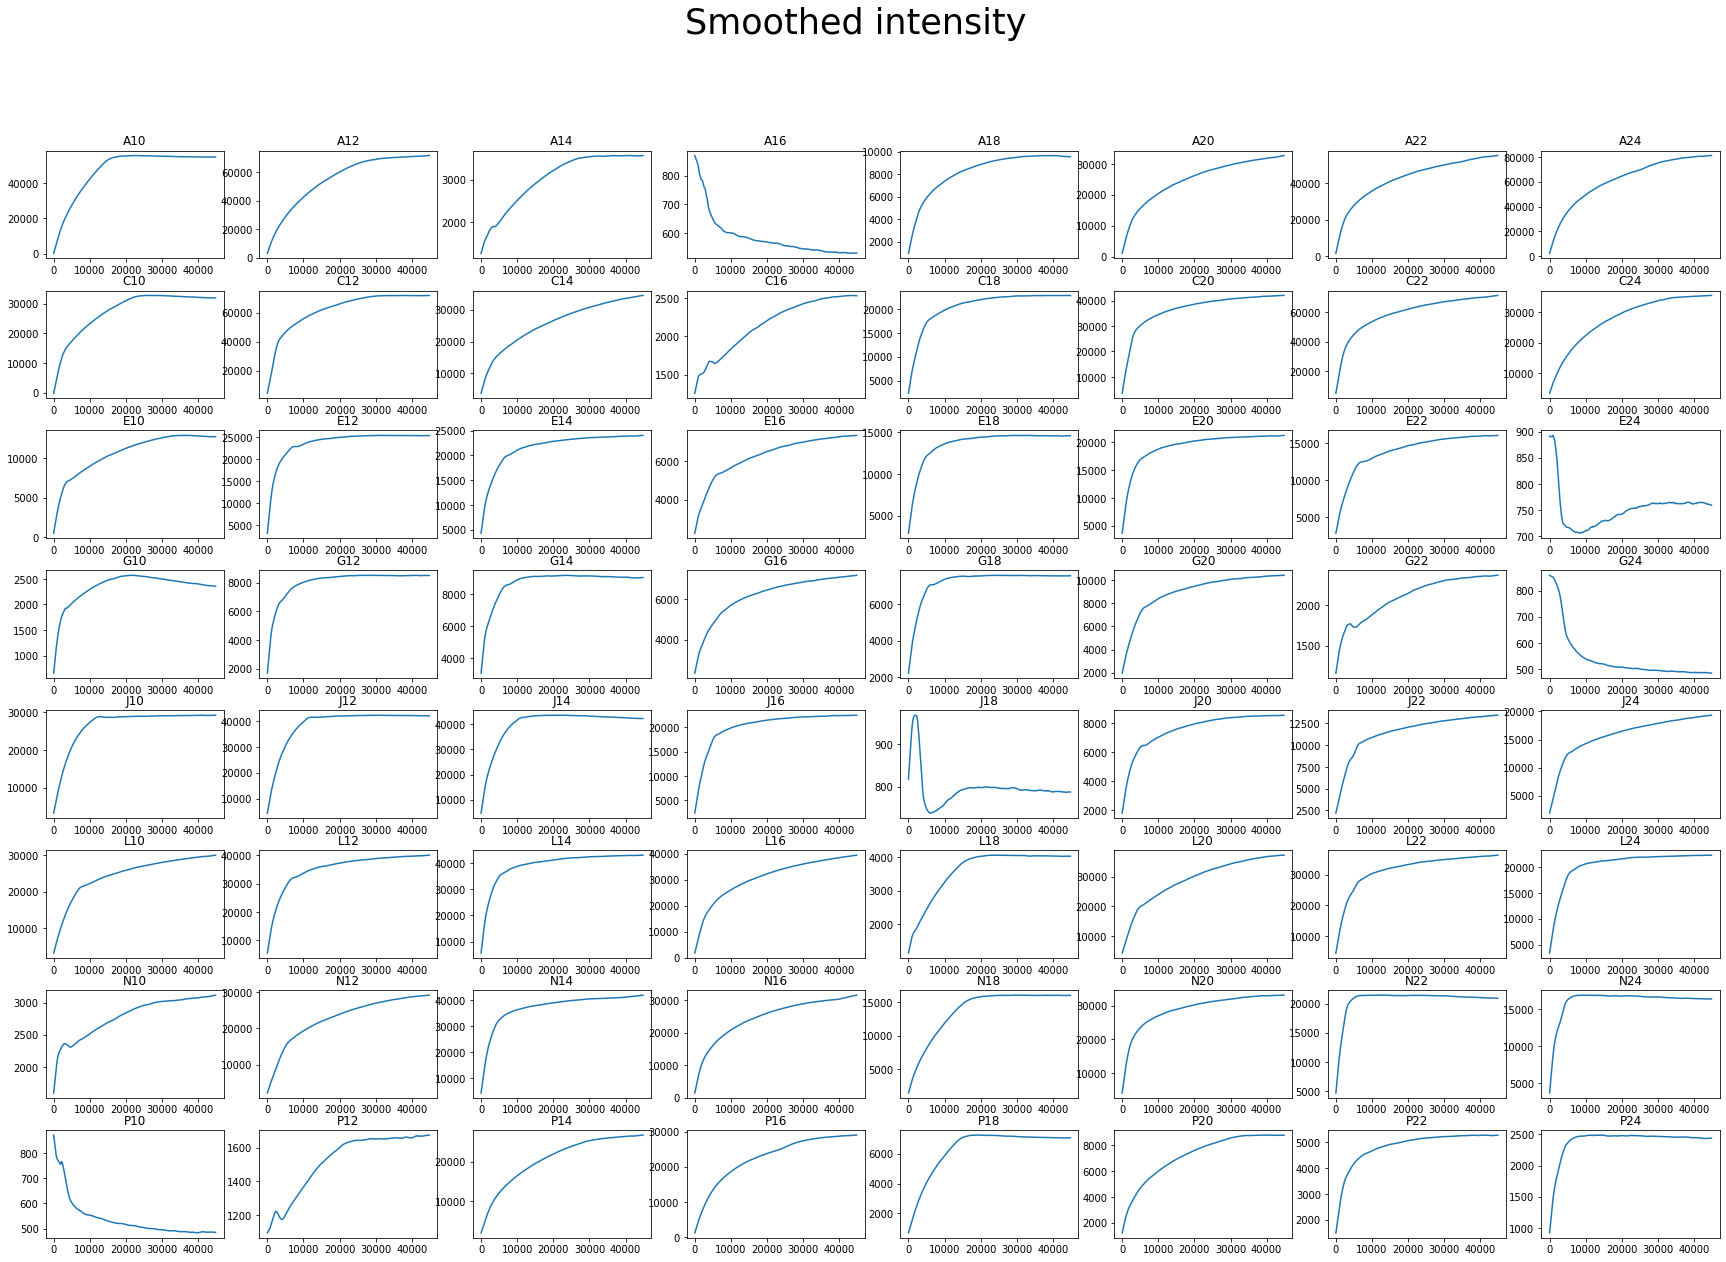

<Figure size 432x288 with 0 Axes>

In [24]:
smoothed=savgol_filter(filled,9,1)
smoothed2=savgol_filter(filled2,9,1)
plot_all_wells([(time,smoothed)],well_names,'Smoothed intensity')

#Plot well plate

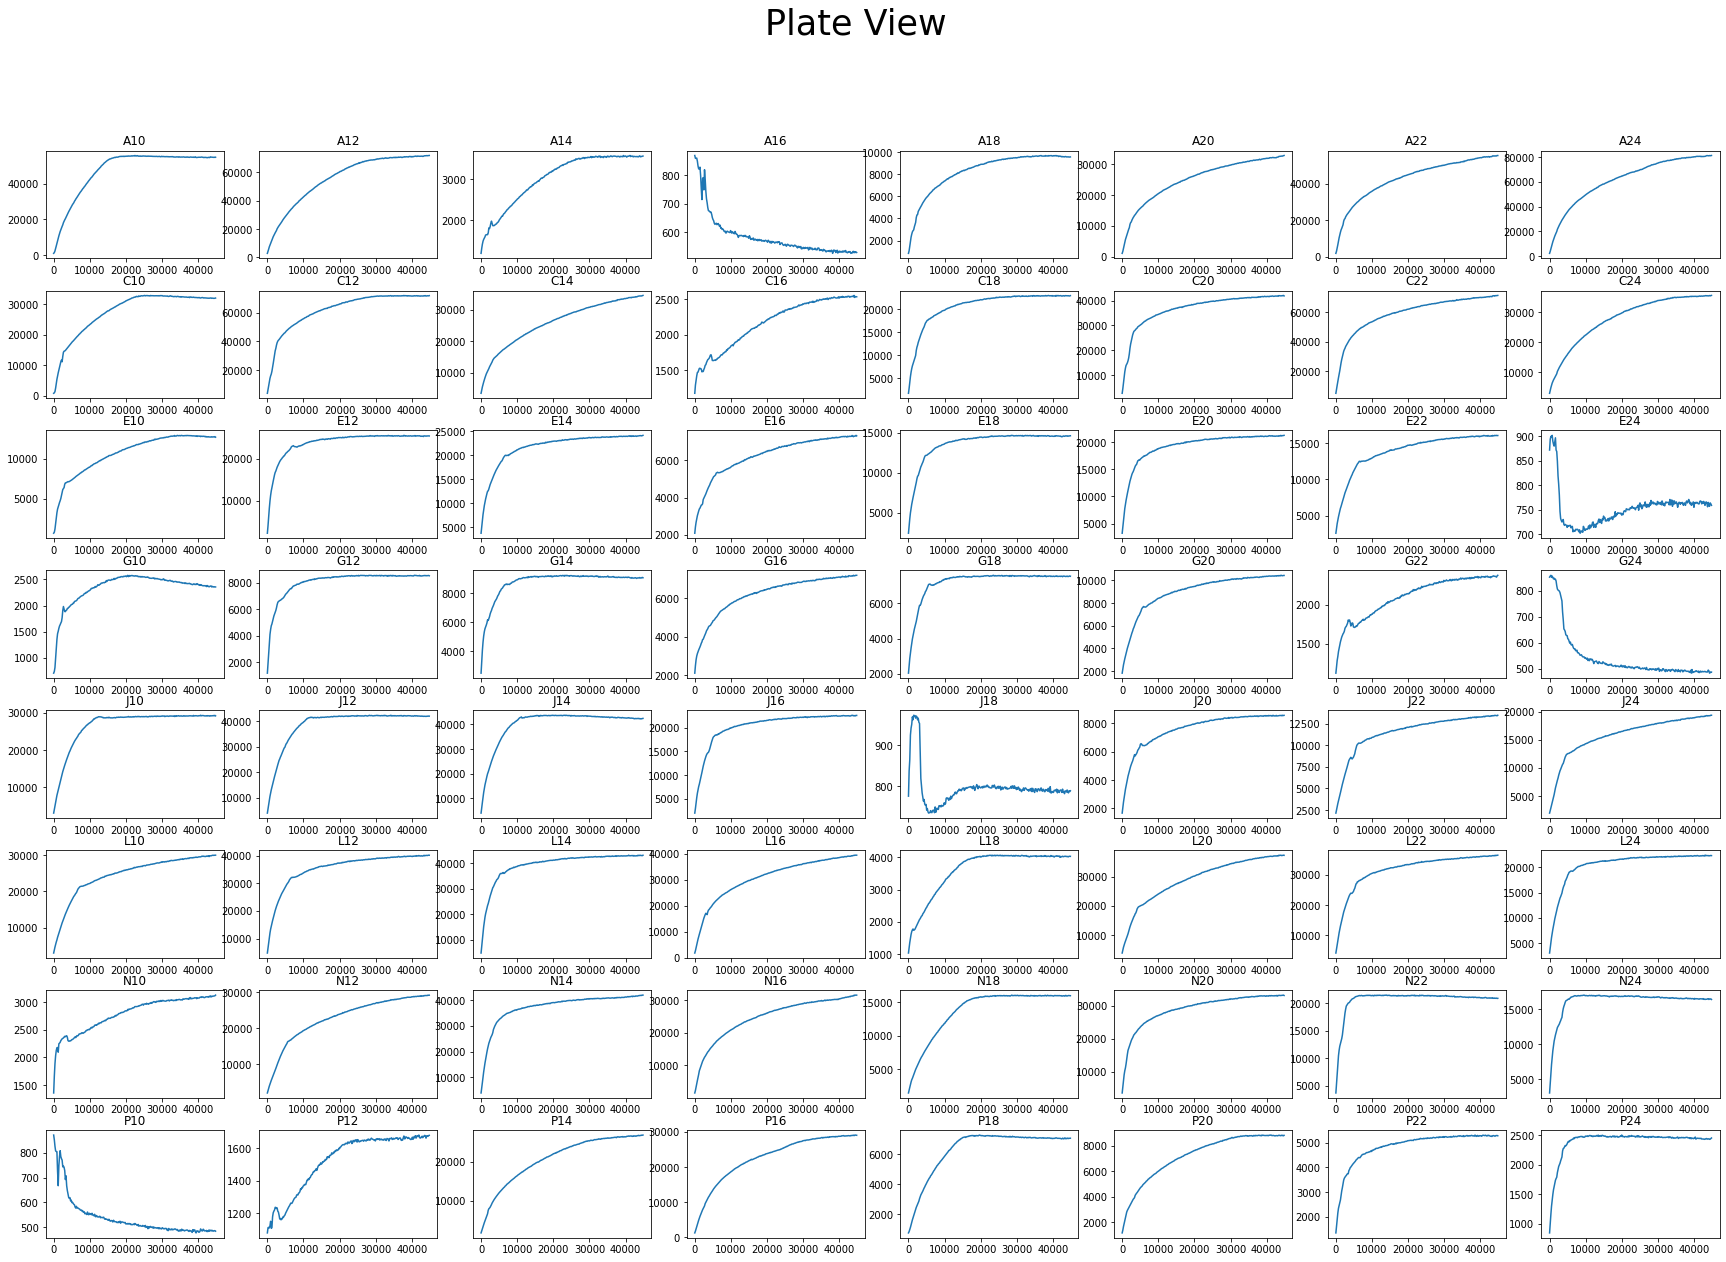

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_all_wells([(time,filled)],well_names,'Plate View')

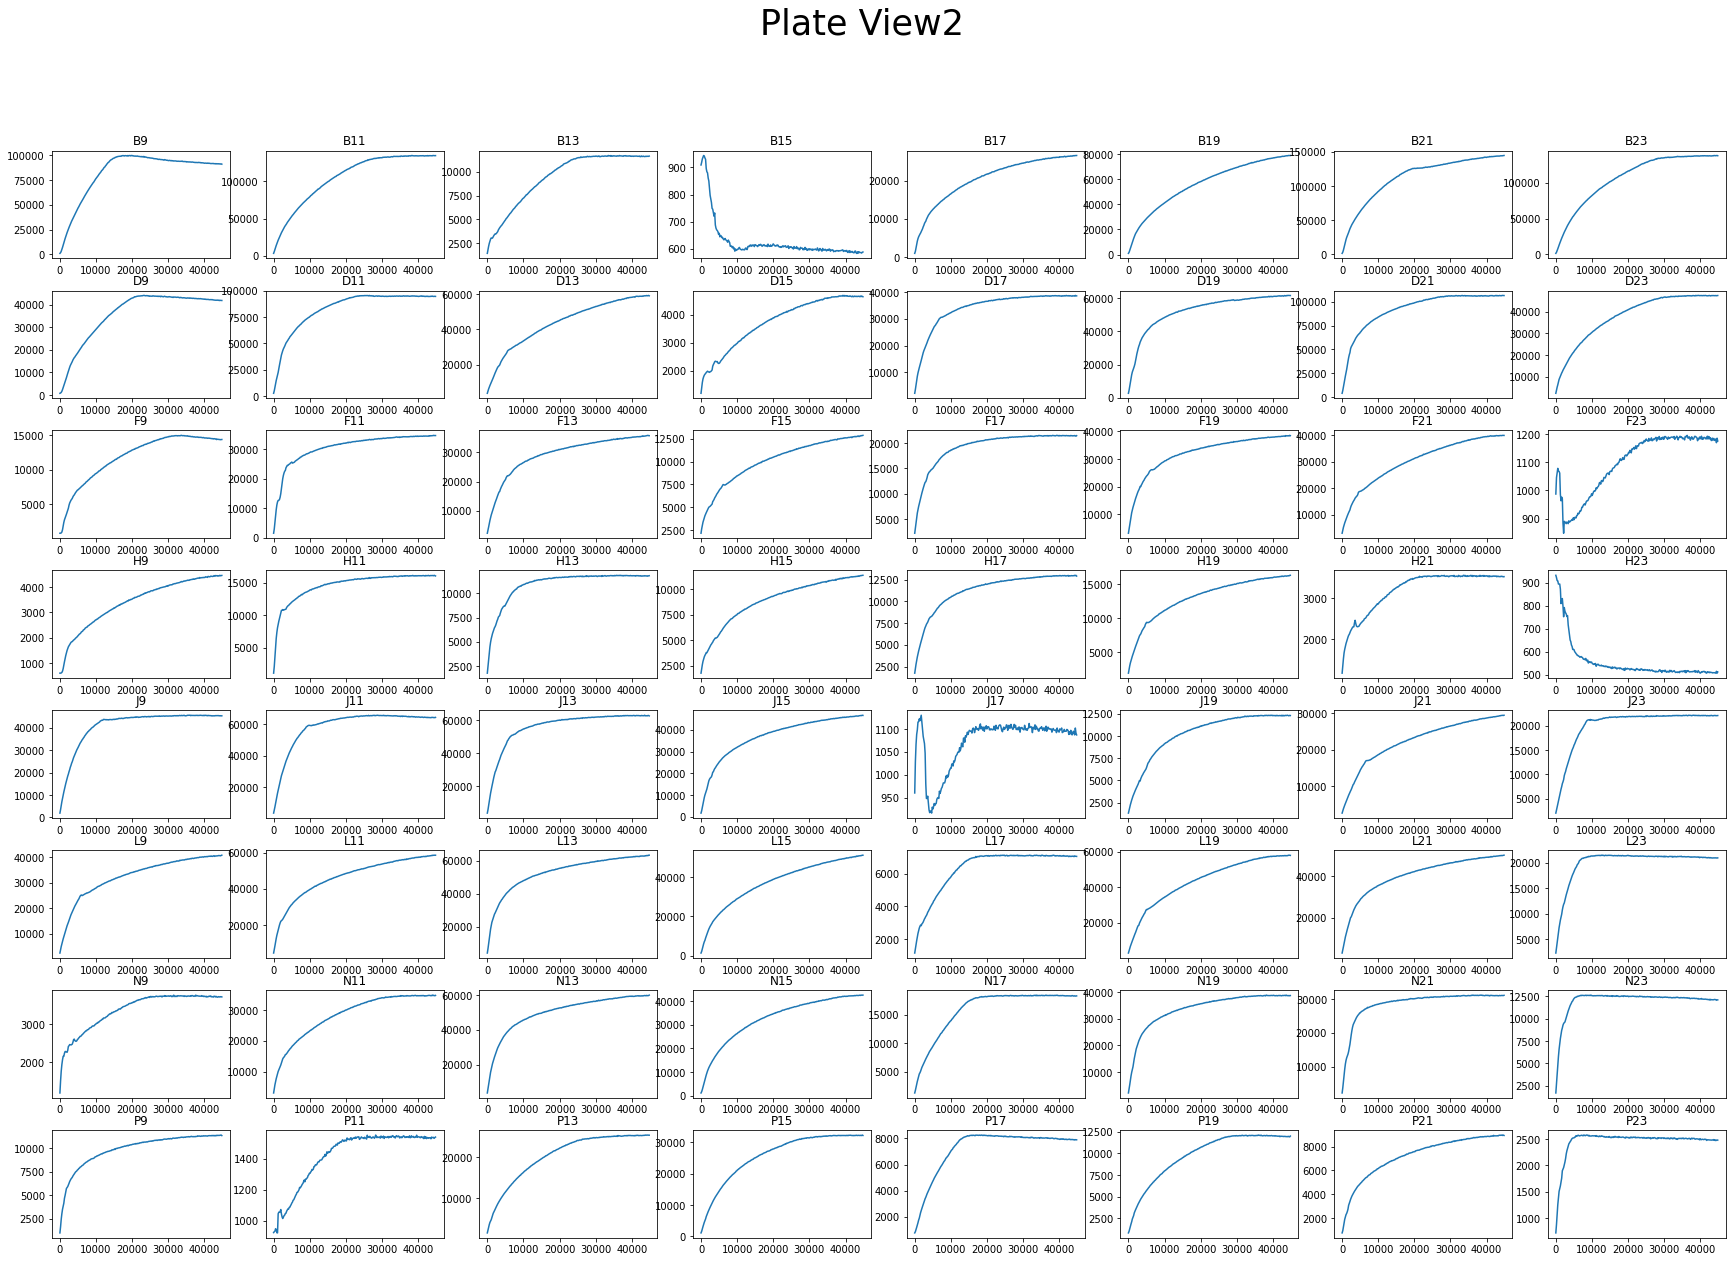

<Figure size 432x288 with 0 Axes>

In [25]:
plot_all_wells([(time,filled2)],well_names2,'Plate View2')

#Labeling (fit)

###trying gradient method

In [ ]:
gradients=np.gradient(smoothed,axis=-1,edge_order=2)
plot_all_wells([(time,gradients)],well_names,'gradients')
max_rates_indices=np.argmax(gradients,axis=-1)
max_rates=np.ones((8,8))
for i in range(dimensions[0]):
  for j in range(dimensions[1]):
    max_rates[i,j]=gradients[i,j,max_rates_indices[i,j]]

<Figure size 2160x1440 with 0 Axes>

In [ ]:
print(max_rates)
print(max_rates_indices)

[[9.48600000e+02 4.59333333e+01 6.13333333e+00 3.18333333e+00
  3.53633333e+02 2.51133333e+02 1.08716667e+02 3.48333333e+01]
 [6.82888889e+02 4.33050000e+02 1.05666667e+02 2.14083333e+01
  4.14586111e+02 3.30666667e+02 1.18400000e+02 5.38888889e+00]
 [1.37900000e+02 1.67100000e+02 1.27033333e+02 3.61333333e+01
  2.93250000e+02 2.25883333e+02 8.62666667e+01 5.44444444e+00]
 [1.29444444e+01 4.67500000e+01 1.86111111e+01 5.46666667e+00
  1.35600000e+02 9.76333333e+01 4.16166667e+01 4.44444444e+00]
 [3.22716667e+02 1.50283333e+02 3.44777778e+01 7.92222222e+00
  1.98666667e+01 1.26733333e+02 6.19000000e+01 3.66666667e+00]
 [4.66350000e+02 2.97266667e+02 5.27611111e+01 1.76305556e+01
  2.59166667e+01 1.85050000e+02 5.87694444e+01 6.00000000e+00]
 [1.45916667e+02 1.07016667e+02 3.69500000e+01 1.71305556e+01
  6.14833333e+01 9.95333333e+01 2.83083333e+01 5.33333333e+00]
 [8.33333333e-01 8.33333333e-01 6.66666667e-01 6.61111111e+00
  1.43616667e+02 4.32000000e+01 4.55555556e+00 4.88888889e+00]]

In [ ]:
initial_rate=np.mean(gradients[:,:,:5],axis=2)
initial_rate

array([[941.69555556,  45.75111111,   6.08666667,   3.09833333,
        350.78111111, 250.24222222, 108.57833333,  27.62833333],
       [678.03166667, 429.08944444, 104.63333333,  21.20166667,
        414.34388889, 328.38888889, 117.52666667, -20.90166667],
       [137.19888889, 165.35666667, 126.50777778,  35.83111111,
        293.05833333, 223.895     ,  85.41777778, -23.71388889],
       [ 12.065     ,  46.30833333,  16.23222222,   5.43111111,
        134.70666667,  96.80333333,  41.29944444, -22.27833333],
       [319.87833333, 149.255     ,  32.28222222,   7.50444444,
         19.71333333, 125.44888889,  61.62111111, -13.37333333],
       [462.23722222, 294.28444444,  52.39222222,  17.51277778,
         25.74722222, 182.81166667,  58.67388889, -11.30222222],
       [144.50277778, 106.25944444,  36.77722222,  16.87944444,
         61.04611111,  99.33555556,  26.955     , -23.41388889],
       [-12.13555556,  -9.22222222,  -3.34222222,  -7.09555556,
        142.11055556,  42.8688888

###Going back to initial rates

I decided to go beck to just fitting a line to the very beginning.

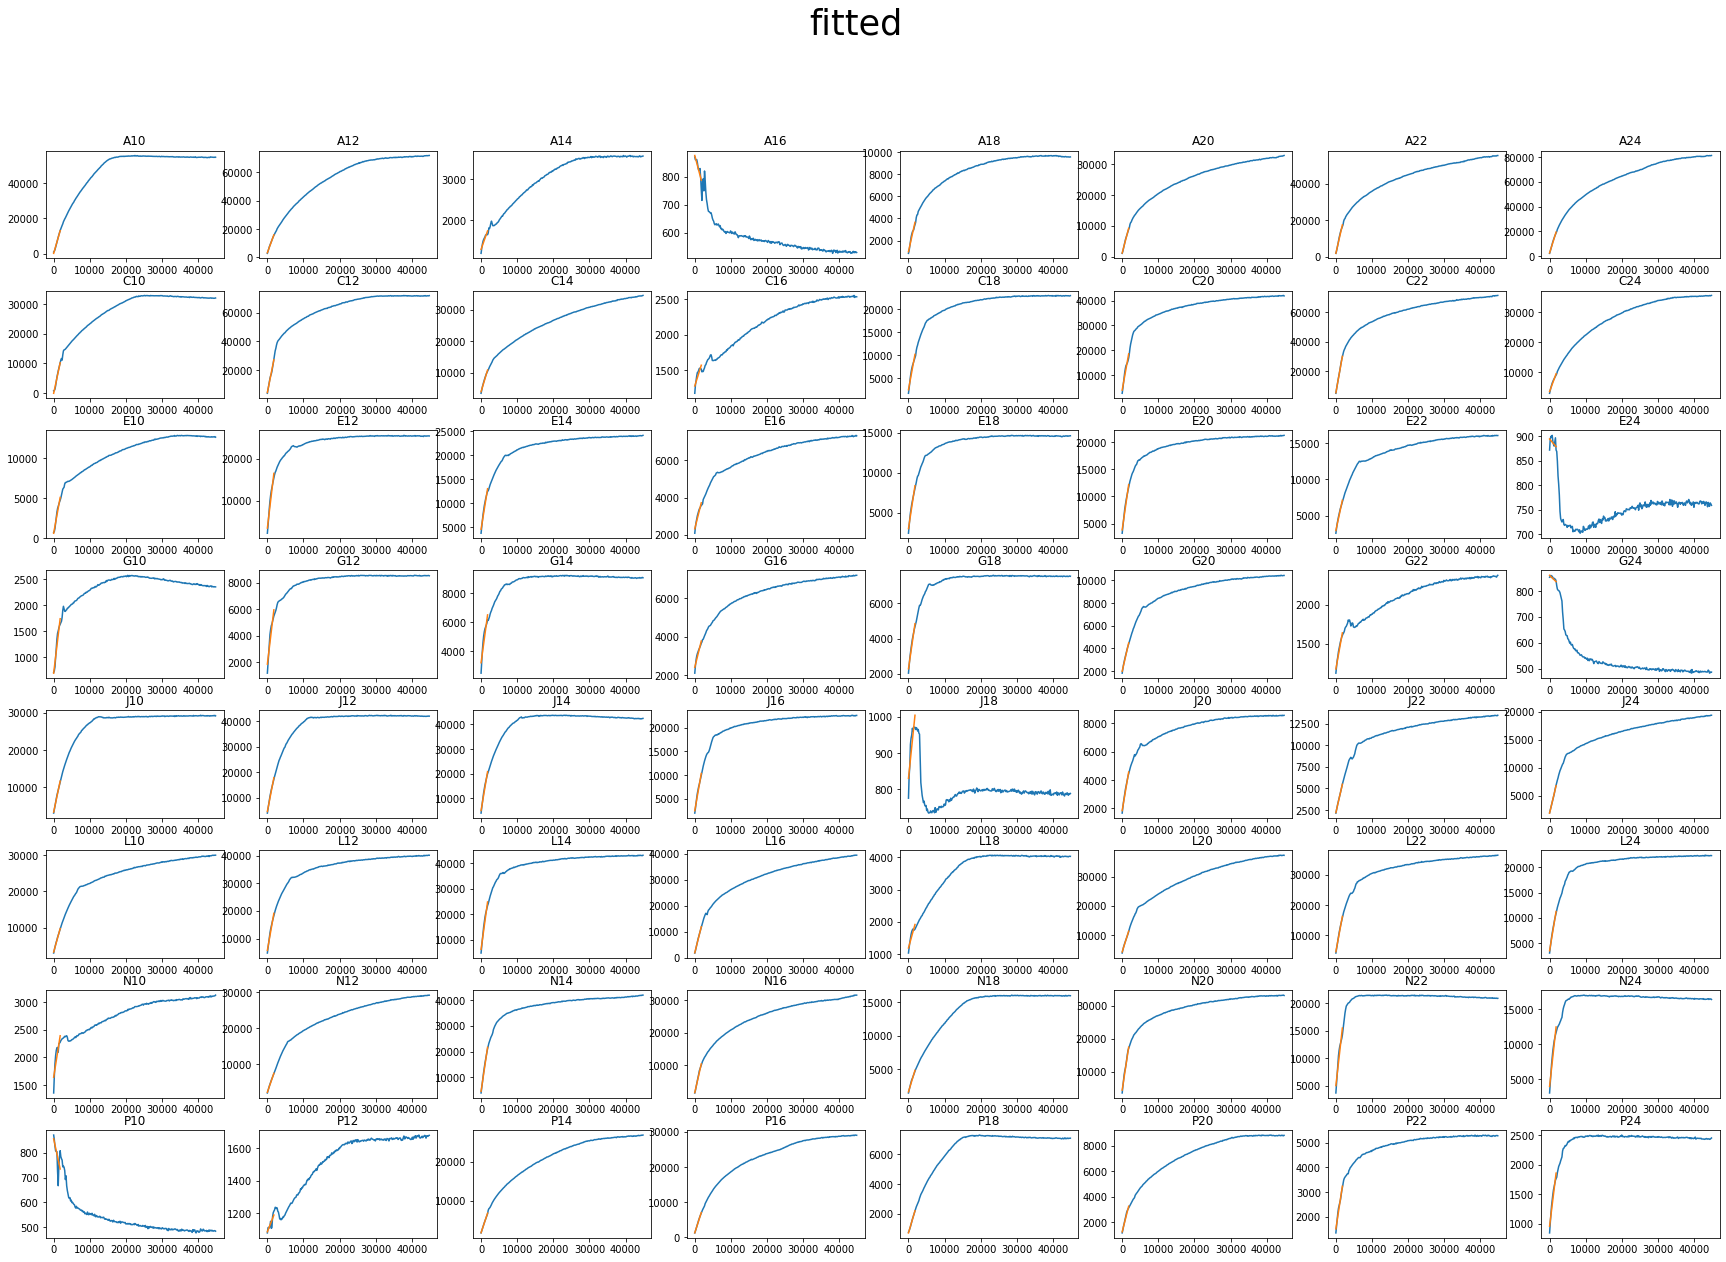

<Figure size 432x288 with 0 Axes>

In [28]:
slopes,intercepts=fit_line_to_range(smoothed,10)
fits=[[[intercepts[i,j],(slopes[i,j]*10*180 + intercepts[i,j])]for j in range(8)]for i in range(8)]
plot_all_wells([(time,filled),([0,10*180],fits)],well_names,'fitted')

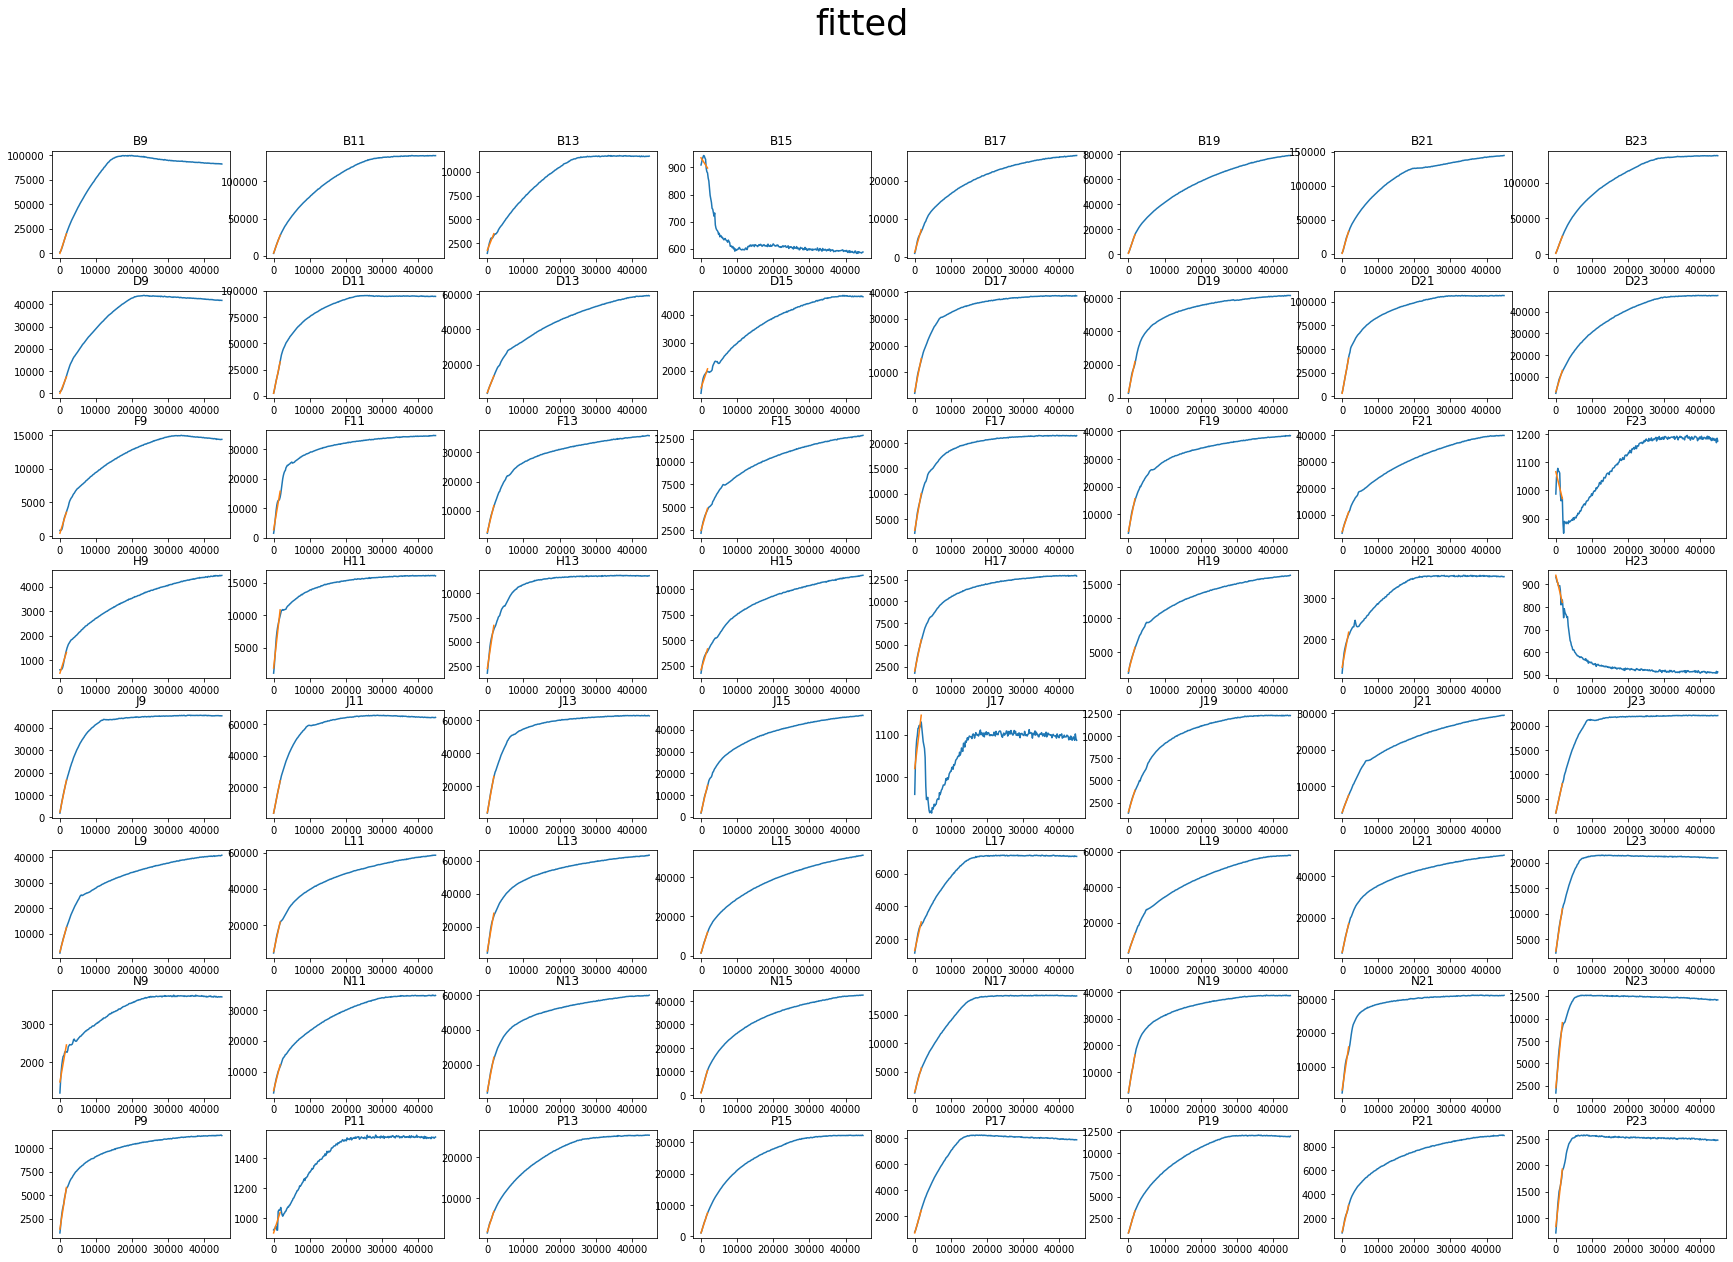

<Figure size 432x288 with 0 Axes>

In [26]:
slopes2,intercepts2=fit_line_to_range(smoothed2,10)
fits2=[[[intercepts2[i,j],(slopes2[i,j]*10*180 + intercepts2[i,j])]for j in range(8)]for i in range(8)]
plot_all_wells([(time,filled2),([0,10*180],fits2)],well_names2,'fitted')

In [32]:
slopes.shape

(8, 8)

In [31]:
slopes1=slopes.copy()
slopes=(slopes1+slopes2)/2

In [37]:
print(slopes1,'\n')
print(slopes2,'\n')
print(slopes,'\n')

[[ 7.11569585e+00  6.98009353e+00  2.50478863e-01 -4.88290311e-02
   1.47332024e+00  4.45493827e+00  8.61145903e+00  9.32991208e+00]
 [ 5.70241302e+00  1.26840292e+01  3.82643098e+00  1.61855593e-01
   4.25463711e+00  8.13212308e+00  1.37882024e+01  3.30936027e+00]
 [ 2.49815189e+00  7.19293490e+00  4.68288440e+00  7.76406659e-01
   2.97766554e+00  4.61446876e+00  2.32797793e+00 -8.60643472e-03]
 [ 5.83381968e-01  2.27242050e+00  1.81861392e+00  7.56391695e-01
   1.42232510e+00  1.38867190e+00  2.57332585e-01 -1.36045642e-02]
 [ 4.61877291e+00  7.34438833e+00  8.74815563e+00  4.36314815e+00
   9.64683876e-02  1.51553685e+00  1.82279274e+00  2.71287692e+00]
 [ 3.59478863e+00  7.42076880e+00  1.03087561e+01  5.54976431e+00
   4.04732510e-01  3.93271418e+00  6.43899925e+00  4.31559110e+00]
 [ 4.16545080e-01  2.91130378e+00  9.48852600e+00  4.88255518e+00
   1.79341003e+00  7.24775346e+00  5.81115788e+00  4.70240554e+00]
 [-6.75084175e-02  5.67508418e-02  2.78121025e+00  3.19568275e+00
   

In [33]:

normalized_slopes=( slopes-slopes.min() )/(slopes.max()-slopes.min())
print(normalized_slopes)
print(normalized_slopes.mean(),normalized_slopes.max(),normalized_slopes.min())

def back_normalization_slopes(label):
  return (label *  (slopes.max()-slopes.min()) )+slopes.min()

[[5.28423955e-01 5.87387326e-01 3.71420977e-02 3.03362265e-04
  1.39493155e-01 3.70468513e-01 7.75089233e-01 6.58146548e-01]
 [2.86346503e-01 8.48136785e-01 2.65027907e-01 1.80192200e-02
  3.23019522e-01 5.34010741e-01 1.00000000e+00 2.56039269e-01]
 [1.24858067e-01 4.19464391e-01 2.84743582e-01 6.37990677e-02
  2.04570214e-01 3.23778903e-01 1.90987301e-01 5.42399591e-04]
 [3.28115174e-02 2.11753093e-01 1.26260968e-01 5.70140060e-02
  1.01688408e-01 9.90102793e-02 2.34265250e-02 0.00000000e+00]
 [3.66049005e-01 5.44143951e-01 6.10260939e-01 3.30813407e-01
  7.13188536e-03 8.52001971e-02 1.31600209e-01 1.77808004e-01]
 [2.60266398e-01 4.80380541e-01 6.67185963e-01 3.31758501e-01
  4.22311379e-02 2.87442628e-01 4.09866860e-01 2.61248505e-01]
 [3.01741949e-02 2.21334203e-01 5.89458026e-01 2.98344378e-01
  1.22010916e-01 4.36759291e-01 3.74762406e-01 2.55596419e-01]
 [7.11564426e-02 6.16511459e-03 1.62107246e-01 1.97161574e-01
  5.43732152e-02 7.52545970e-02 6.61574682e-02 3.43266488e-02]]

#building data set

##Protocol to Inputs

In [38]:

scanning_profile=OrderedDict({'t3r5':(100,0.5),'template':(50,0.5),'mgcl2':(20,0.5),'rntp':(5,0.5)})
grid_profile_keys=[[1,2,1,2],[1,2,2,-1],[1,2,-1,-2],[1,2,-2,1]]

##function to turn profile keys to concentrations in 8*8

def fill_a_block(direction,initial_concentration,dilution_coefficient,n_wells_in_block=4,real_concentrations=False):
  if real_concentrations:
    diluted_concentraitions=dilution_concentraitions(initial_concentration,dilution_coefficient,n_wells_in_block)
  else:
    diluted_concentraitions=dilution_concentraitions(1,dilution_coefficient,n_wells_in_block) #fix for next iteration

  if direction<0:
    diluted_concentraitions.reverse()
  direction=abs(direction)
  block=np.stack([diluted_concentraitions]*n_wells_in_block,axis=direction-1)
  return block


def dilution_concentraitions(initial_concentration,dilution_coefficient,number_of_wells=4):
  concentrations=[]
  c=initial_concentration
  for i in range(number_of_wells):
    concentrations.append(c)
    c=c*dilution_coefficient
  return concentrations

def build_grid_out_of_blocks(block1,block2,block3,block4):
  l1=np.concatenate((block1,block2),axis=1)
  l2=np.concatenate((block3,block4),axis=1)
  return np.concatenate((l1,l2),axis=0)
  #this only works with 4 blocks. I don't know how we want to represent more number of blocks. Update in future cases.

def grid_profile_to_concentration(scanning_profile,grid_profile_keys,real_concentrations=False):
  number_of_elements=len(scanning_profile)
  number_of_blocks=len(grid_profile_keys)
  concentrations=OrderedDict({})
  for i,material in enumerate(scanning_profile):
    blocks=[]
    for b in range (number_of_blocks):
      direction=grid_profile_keys[b][i]
      block=fill_a_block(direction,scanning_profile[material][0],scanning_profile[material][1],real_concentrations=real_concentrations)
      blocks.append(block)
    concentrations[material]=build_grid_out_of_blocks(blocks[0],blocks[1],blocks[2],blocks[3])

  return concentrations

scanning_concentrations=grid_profile_to_concentration(scanning_profile,grid_profile_keys)
for element in scanning_concentrations:
  print(element,'\n',scanning_concentrations[element])
  print(scanning_concentrations[element].shape)
  scanning_concentrations[element]=scanning_concentrations[element].flatten()
  print(scanning_concentrations[element].shape)


t3r5 
 [[1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]]
(8, 8)
(64,)
template 
 [[1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ]
 [0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25 ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ]
 [0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25 ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]
(8, 8)
(64,)
mgcl2 
 [[1.    0.5   0.25  0.125 1.    1.    1.    1.   ]
 [1.    0.5   0.25  0.125 0.5   0.5   0.5   0.5  ]
 [1.    0.5   0.25  0.125 0.

##checking the distribution

In [39]:
def plot_3d_distribution (xs,ys,zs,name,xlabel='x',ylabel='y',zlabel='z'):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs, ys, zs, zdir='z')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  plt.show()
  plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

def plot_2d_distribution (x,y,name,xlabel='x',ylabel='y'):
  #fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=100)
  fig, ax = plt.subplots()
  plt.scatter(x,y,alpha=0.2)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  plt.show()
  plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

('t3r5', 'template', 'mgcl2')
(64,) (64,) (64,)


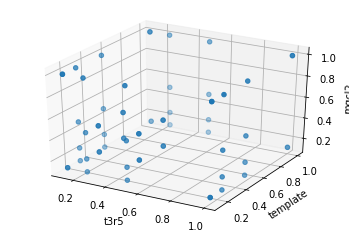

('t3r5', 'template', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

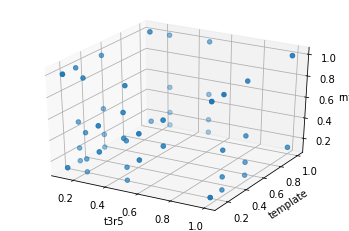

('t3r5', 'mgcl2', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

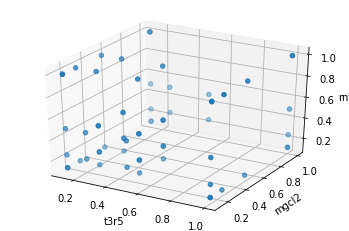

('template', 'mgcl2', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

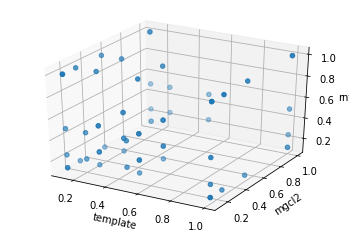

<Figure size 432x288 with 0 Axes>

In [40]:

comb=combinations(scanning_profile,3)
for names in comb:
  print(names)
  xlabel,ylabel,zlabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  zs=scanning_concentrations[zlabel]
  print(xs.shape,ys.shape,zs.shape)
  plot_3d_distribution(xs,ys,zs,str(names),xlabel,ylabel,zlabel)

('t3r5', 'template')


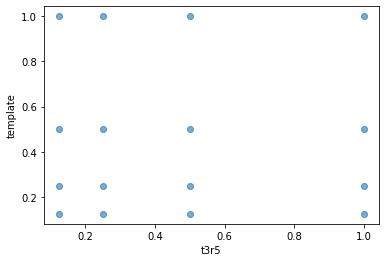

('t3r5', 'mgcl2')


<Figure size 432x288 with 0 Axes>

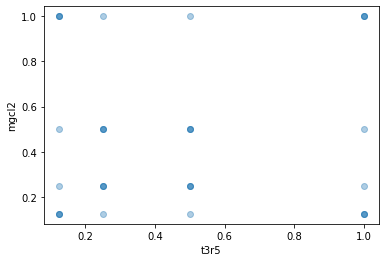

('t3r5', 'rntp')


<Figure size 432x288 with 0 Axes>

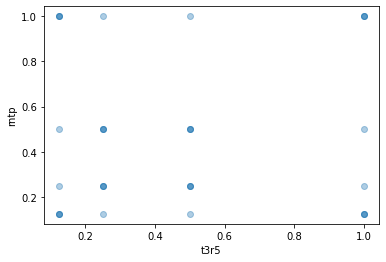

('template', 'mgcl2')


<Figure size 432x288 with 0 Axes>

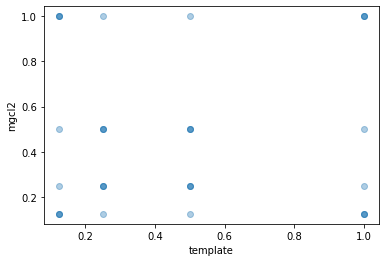

('template', 'rntp')


<Figure size 432x288 with 0 Axes>

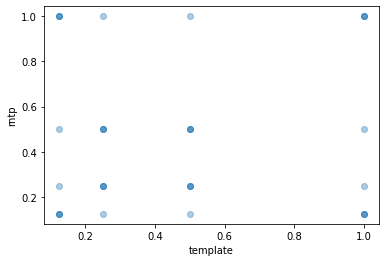

('mgcl2', 'rntp')


<Figure size 432x288 with 0 Axes>

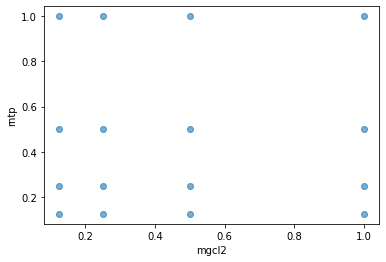

<Figure size 432x288 with 0 Axes>

In [ ]:
comb=combinations(scanning_profile,2)
for names in comb:
  print(names)
  xlabel,ylabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  plot_2d_distribution(xs,ys,str(names),xlabel,ylabel)

##building dataset (connecting inputs and output)

In [41]:
#How do I want my dataset to look like? 64 flattened wells, containing 4 infos each
dataset_size=dimensions[0]*dimensions[1]
dataset_x=np.array([[scanning_concentrations[element][i] for element in scanning_concentrations] for i in range(dataset_size)])
dataset_y=normalized_slopes.flatten()

In [42]:
print(dataset_x.shape)
print(dataset_x[0],dataset_x[63])
print(dataset_y.shape)

(64, 4)
[1. 1. 1. 1.] [0.125 0.125 1.    0.125]
(64,)


#Training a NN model

In [43]:
x_train,x_test,y_train,y_test = train_test_split(dataset_x,dataset_y,test_size=0.1,random_state=100)

In [44]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(57, 4) (7, 4) (57,) (7,)


In [45]:
print(x_train[0])

[0.5  1.   1.   0.25]


model description

In [46]:
iter1_model = Sequential([
                    Dense(10,activation='relu', input_shape=(4,),name='layer1')])
#iter1_model.add(LeakyReLU(alpha=0.01))
iter1_model.add(Dense(6,activation='relu',name='layer2'))
#iter1_model.add(Dense(4,activation='relu',name='layer3'))
iter1_model.add(Dense(1,activation='relu',name='output'))

compilation

In [47]:
iter1_model.compile(
    optimizer='adam',
    loss='MeanSquaredError', #MeanSquaredLogarithmicError
)

iter1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 10)                50        
_________________________________________________________________
layer2 (Dense)               (None, 6)                 66        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


training

In [48]:
iter1_history=iter1_model.fit(x_train,y_train,batch_size=5,epochs=400)
loss_history=iter1_history.history['loss']

Epoch 1/400
12/12 [==============================] - 0s 1ms/step - loss: 0.1034
Epoch 2/400
12/12 [==============================] - 0s 2ms/step - loss: 0.1022
Epoch 3/400
12/12 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 4/400
12/12 [==============================] - 0s 1ms/step - loss: 0.1000
Epoch 5/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0992
Epoch 6/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0971
Epoch 7/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0901
Epoch 8/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 9/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0735
Epoch 10/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0702
Epoch 11/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0656
Epoch 12/400
12/12 [==============================] - 0s 1ms/step - loss: 0.0600
Epoch 13/400
12/12 [=================

evaluate

###plotting Learning curve (loss history)

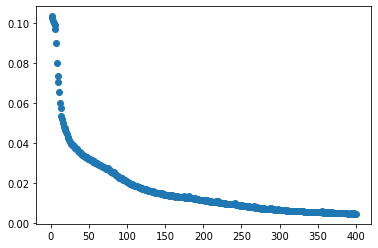

<Figure size 432x288 with 0 Axes>

In [49]:
epochs=np.arange(1,401)
plt.scatter(x=epochs,y=loss_history)
plt.show()
save_plot_to_file('Learning_Curve'+str(tm.datetime.now()))
save_model_to_file(iter1_model,'NN_model'+str(tm.datetime.now()))

In [50]:
loss=iter1_model.evaluate(x_test,y_test)
print(loss)

1/1 [==============================] - 0s 1ms/step - loss: 0.0161
0.0161411352455616


In [51]:
print(iter1_model.predict([[1,1,1,1]]))

[[0.6511153]]


#Using the trained model to find the maximum Yield

In [52]:
def generate_grid(n_scanning_parameters,n_points_each_dimension,high=1,low=0):
  points=np.linspace(high,low,num=n_points_each_dimension)
  x_points=[points for dimension in range(n_scanning_parameters)]
  mesh=np.array(np.meshgrid(*x_points))
  return mesh

def generate_random_grid(n_scanning_parameters,n_points_each_dimension,high=1,low=0):
  #points=np.random()
  x=1

def predict_grid(mesh,model):
  mesh=mesh.T
  points=np.array( [mesh[index].T for index in np.ndindex(*mesh.shape[1:])] )
  preds=model.predict(points)
  return points,preds

def find_max(mesh,model):
  points,preds=predict_grid(mesh,model)
  print('all predicted')
  max_array_index=np.argmax(preds)
  max=preds[max_array_index]
  max_index=points[max_array_index]
  return max,max_index

def find_n_maxes(mesh,model,n):
  points,preds=predict_grid(mesh,model)
  print('all predicted')
  preds=preds.reshape((4000000))
  sorted_indices=np.argsort(preds)
  max=preds[sorted_indices][::-1]
  max_index=points[sorted_indices][::-1]
  return max[:n],max_index[:n]

In [53]:
grid=generate_grid(4,50,high=4)
print(grid.shape)
#max,max_index=find_n_maxes(grid,iter1_model,10)
points,preds=predict_grid(grid,iter1_model)

(4, 50, 50, 50, 50)


In [54]:
preds=preds.reshape((500000))
sorted_indices=np.argsort(preds)
sorted=preds[sorted_indices]
sorted_points=points[sorted_indices]
for i in range(100):
  print(sorted[-1-i],sorted_points[-i-1])

2.0548403 [2.28571429 4.         2.53061224 1.46938776]
2.0419335 [2.28571429 4.         2.53061224 1.3877551 ]
2.0270503 [2.36734694 4.         2.44897959 1.3877551 ]
2.0269127 [2.28571429 4.         2.44897959 1.3877551 ]
2.0234342 [2.28571429 3.91836735 2.44897959 1.3877551 ]
2.020822 [2.28571429 4.         2.44897959 1.46938776]
2.016812 [2.20408163 3.83673469 2.44897959 1.3877551 ]
2.0159783 [2.36734694 4.         2.53061224 1.3877551 ]
2.010453 [2.36734694 4.         2.44897959 1.30612245]
2.0097842 [2.20408163 3.91836735 2.44897959 1.46938776]
2.0090816 [2.20408163 4.         2.53061224 1.46938776]
2.0069976 [2.20408163 3.91836735 2.44897959 1.3877551 ]
2.0064325 [2.20408163 3.91836735 2.53061224 1.46938776]
2.0049484 [2.28571429 4.         2.6122449  1.46938776]
2.004508 [2.20408163 4.         2.53061224 1.55102041]
2.0041022 [2.28571429 4.         2.44897959 1.30612245]
1.9953921 [2.20408163 4.         2.6122449  1.55102041]
1.9950528 [2.20408163 4.         2.6122449  1.469387

In [ ]:

max_array_index=np.argmax(preds)
max=preds[max_array_index]
max_index=points[max_array_index]
print(max,max_index)

[1.1679085] [0.         3.95959596 2.02020202 2.54545455]


# Producing next protocol closer to minima

We decided to fix polymerase concentration and instead scan spermidine (now present in NEB RNApol reaction buffer)